# Assignment 2

2.2

Write a DES program to verify this for n=1, n=2 and n=4. Make sure that your result
has a high and known statistical significance. How does the number of measurements
required to attain this, depend on $\rho$?

In [5]:
import random
import math
import simpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [448]:
# Init variables
RANDOM_SEED = 42
N_helpers = [1, 2, 4]  # Number of machines in the queue
serveTime = 13          # Minutes it takes to help a customer
lambdaIAT = [12*N for N in N_helpers]          # Create a customer every ~7 minutes
SIM_TIME = 80          # Simulation time in minutes
NRUNS = 100             # Amount of runs
customerCount = [50*N for N in N_helpers]   # Amount of customers

# Choose your queueing system
# resources = [simpy.PriorityResource]
resources = [simpy.Resource]
# resources = [simpy.Resource, simpy.PriorityResource]

# Create Queue object
class Queue(object):
    def __init__(self, env, N, serveTime, resource):
        self.env = env
        self.machine = resource(env, N)
        self.serveTime = serveTime
        self.customerHelped = 0
        self.helperN = N

    def helped(self, customer, customerServeWait=serveTime):
        yield self.env.timeout(customerServeWait)

# Customer with its own serviceTime
def customer(env, name, cw, id, customerServeWait, resource):
    customerServeWait = random.randint(serveTime - 5, serveTime + 5)
    enterQueue = env.now
    if resource == simpy.PriorityResource:
        with cw.machine.request(priority=customerServeWait) as request:
            request.name = name
            request.time = customerServeWait
            yield request

            customerStat[cw.helperN].append(env.now - enterQueue)
            yield env.process(cw.helped(name, customerServeWait=customerServeWait))

    elif resource == simpy.Resource:
        with cw.machine.request() as request:
            request.name = name
            request.time = customerServeWait
            yield request

            customerStat[cw.helperN].append(env.now - enterQueue)
            yield env.process(cw.helped(name, customerServeWait=customerServeWait))


def setup(env, N, serveTime, lambdaIAT, customerCount, resource):
    queue = Queue(env, N, serveTime, resource)

    # Create more customers while the simulation is running
    while queue.customerHelped < customerCount:
        s = np.random.poisson(lambdaIAT, customerCount)
        yield env.timeout(s[queue.customerHelped])
        queue.customerHelped += 1
        env.process(
            customer(env, 'customer %d' % queue.customerHelped, queue,
                     queue.customerHelped,
                     (customerCount - queue.customerHelped), resource))

for resource in resources:
    random.seed(RANDOM_SEED)
    customerStat = {}
    for j in range(NRUNS):
        for nIndex, N in enumerate(N_helpers):
            customerStat.setdefault(N, [])
            customerStat.setdefault(str(N) + "P", [])
            customerStat[str(N) + "P"].append(lambdaIAT[nIndex] / (N * serveTime))
            env = simpy.Environment()
            env.process(
                setup(env, N, serveTime, lambdaIAT[nIndex], customerCount[nIndex], resource))
            env.run()
    
    # Format data    
    customerStatDf = pd.DataFrame({"Helpers": N_helpers, 
                                  "$\rho$": [np.mean(customerStat[str(N)+'P']).round(decimals=2) for N in N_helpers],
                                  "Average": [np.mean(customerStat[N]).round(decimals=2) for N in N_helpers], 
                                  "Variance": [np.var(customerStat[N]).round(decimals=2) for N in N_helpers],
                                  "std.dev": [np.std(customerStat[N]).round(decimals=2) for N in N_helpers]}).set_index('Helpers')
    
    # Print output    
    print(f"For {str(resource)[33:-2]}")
    display(HTML(customerStatDf.T.to_html()))
    print()


For Resource


Helpers,1,2,4
$\rho$,0.92,0.92,0.92
Average,32.07,0.00,0.00
Variance,705.76,0.00,0.00
std.dev,26.57,0.00,0.00


## 2.3

Also compare the result to that for an M/M/1 queue with shortest job first scheduling,
where you always give priority to the smallest jobs.

In [3]:
# Init variables
RANDOM_SEED = 42
N_helpers = [1, 2, 4]  # Number of machines in the queue
waitTime = 6          # Minutes it takes to help a customer
lambdaIAT = 6          # Create a customer every ~7 minutes
SIM_TIME = 80          # Simulation time in minutes
NRUNS = 10             # Amount of runs
customerCount = 1000   # Amount of customers

# Choose your queueing system
# resources = [simpy.PriorityResource]
# resources = [simpy.Resource]
resources = [simpy.Resource, simpy.PriorityResource]


class Queue(object):
    def __init__(self, env, N, waitTime, resource):
        self.env = env
        self.machine = resource(env, N)
        self.waitTime = waitTime
        self.customerHelped = 0
        self.helperN = N

    def helped(self, customer, customerWait=waitTime):
        yield self.env.timeout(customerWait)


def customer(env, name, cw, id, customerWait, resource):
    customerWait = random.randint(waitTime - 5, waitTime + 5)
    enterQueue = env.now
    if resource == simpy.PriorityResource:
        with cw.machine.request(priority=customerWait) as request:
            request.name = name
            request.time = customerWait
            yield request

            customerStat[cw.helperN].append(env.now - enterQueue)
            yield env.process(cw.helped(name, customerWait=customerWait))

    elif resource == simpy.Resource:
        with cw.machine.request() as request:
            request.name = name
            request.time = customerWait
            yield request

            customerStat[cw.helperN].append(env.now - enterQueue)
            yield env.process(cw.helped(name, customerWait=customerWait))


def setup(env, N, waitTime, lambdaIAT, customerCount, resource):
    queue = Queue(env, N, waitTime, resource)

    # Create more customers while the simulation is running
    while queue.customerHelped < customerCount:
        s = np.random.poisson(lambdaIAT, customerCount)
        yield env.timeout(s[queue.customerHelped])
        queue.customerHelped += 1
        env.process(
            customer(env, 'customer %d' % queue.customerHelped, queue,
                     queue.customerHelped,
                     (customerCount - queue.customerHelped), resource))

for resource in resources:
    random.seed(RANDOM_SEED)
    customerStat = {}
    for j in range(NRUNS):
        for N in N_helpers:
            #         print(f"******** N={N} Helpers ********")
            customerStat.setdefault(N, [])
            customerStat.setdefault(str(N) + "P", [])
            customerStat[str(N) + "P"].append(lambdaIAT / (N * waitTime))
            env = simpy.Environment()
            env.process(
                setup(env, N, waitTime, lambdaIAT, customerCount, resource))
            env.run()
    customerStatDf = pd.DataFrame({"Helpers": N_helpers, 
                                  "$\rho$": [np.mean(customerStat[str(N)+'P']).round(decimals=2) for N in N_helpers],
                                  "Average": [np.mean(customerStat[N]).round(decimals=2) for N in N_helpers], 
                                  "Variance": [np.var(customerStat[N]).round(decimals=2) for N in N_helpers],
                                  "std.dev": [np.std(customerStat[N]).round(decimals=2) for N in N_helpers]}).set_index('Helpers')
    print(f"For {str(resource)[33:-2]}")
    display(HTML(customerStatDf.T.to_html()))
    print()


For Resource


Helpers,1,2,4
$\rho$,1.00,0.50,0.25
Average,74.17,0.14,0.00
Variance,3482.87,0.40,0.00
std.dev,59.02,0.63,0.02



For PriorityResource


Helpers,1,2,4
$\rho$,1.00,0.50,0.25
Average,35.09,0.14,0.00
Variance,16765.20,0.41,0.00
std.dev,129.48,0.64,0.02


## 2.4

Now experiment with different service rate distributions. On the one hand try the
M/D/1 and M/D/n queues, on the other hand try a long-tail distribution. For the latter
you may e.g. use a distribution where 75% of the jobs have an exponential distribution
with an average service time of 1.0 and the remaining 25% an exponential distribution
with an average service time of 5.0 (an example of a hyperexponential distribution).

In [465]:
# Init seed
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Init service schemes
serviceScheme = "Long-Tailed"  # Can be "Long-Tailed", "Poisson", "Deterministic", "Inverse", "Random"
serviceSchemes = [
    "Long-Tailed", "Poisson", "Deterministic", "Inverse", "Random"
]

# Init simulation specific parameters
N_helpers = [1, 2, 4]  # Number of machines in the queue
SIM_TIME = 80  # Simulation time in minutes
NRUNS = 5  # Amount of runs
chanceLongTail = 0.75  # Chance of longtail lowerbound
lI = 12
lambdaIAT = [N * lI for N in N_helpers]  # Create a customer every ~lI minutes
cC = 300
customerCount = [N * cC for N in N_helpers]  # Amount of customers

# Init servicetimes
serviceTime = [13 for N in N_helpers
               ]  # Minutes it takes to help a customer / Deterministic
ltLow = [10 for N in N_helpers]  # Lower bound long-tailed distribution
ltHigh = [50 for N in N_helpers]  # Upper bound long-tailed distribution
randspread = [1 for N in N_helpers]  # Spread of the random distribution
invMax = [45
          for N in N_helpers]  # max waiting time for the inverse servicetime
qServeInv = [[
    i for i in range(invMax[queueIndex], -1, -1)
    for x in range(math.ceil(customerCount[queueIndex] / invMax[queueIndex]))
] for queueIndex in range(len(N_helpers))]

# print(f"Rho Deterministic:\t {(lambdaIAT[0]) / (N * (1/serviceTime[0]))}")
# print(f"Rho Poisson/random:\t {(lambdaIAT[0]) / (N * (1/serviceTime[0]))}")
# print(f"Rho Inverse:\t {(lambdaIAT[0]) / (N * (1/np.mean(serviceTime)))}")
# print(f"Rho Long-Tailed:\t {(lambdaIAT[0]) / (N * (1/(0.75*ltL + 0.25*ltH)))}")

# Choose your queueing system
# resources = [simpy.PriorityResource]
# resources = [simpy.Resource]
resources = [simpy.Resource, simpy.PriorityResource]


class Queue(object):
    def __init__(self, env, N, resource, helperIndex):
        self.env = env
        self.machine = resource(env, N)
        self.customerHelped = 0
        self.serverN = N
        self.helperIndex = helperIndex

    def helped(self, customer, customerServe):
        yield self.env.timeout(customerServe)


def customer(env, cw, resource, serviceScheme):
    if serviceScheme == "Long-Tailed":
        rCheck = random.random()
        if rCheck <= 0.75:
            customerServeTime = np.random.poisson(ltLow[cw.helperIndex])
        else:
            customerServeTime = np.random.poisson(ltHigh[cw.helperIndex])
    elif serviceScheme == "Poisson":
        customerServeTime = np.random.poisson(waitTime[cw.helperIndex])
    elif serviceScheme == "Random":
        customerServeTime = random.uniform(
            waitTime[cw.helperIndex] - randspread[cw.helperIndex],
            waitTime[cw.helperIndex] + randspread[cw.helperIndex])
    elif serviceScheme == "Deterministic":
        customerServeTime = waitTime[cw.helperIndex]
    elif serviceScheme == "Inverse":
        customerServeTime = qServeInv[cw.helperIndex][cw.customerHelped]

    customerServeTime = 0.000001 if customerServeTime == 0 else customerServeTime
    
    tmpRho.append(lambdaIAT[cw.helperIndex] / (cw.serverN * customerServeTime))

    enterQueue = env.now
    if resource == simpy.PriorityResource:
        with cw.machine.request(priority=customerServeTime) as request:
            request.time = customerServeTime
            yield request

            tmpWait.append(env.now - enterQueue)
            tmpServe.append(customerServeTime)
            yield env.process(cw.helped(cw.customerHelped, customerServeTime))

    elif resource == simpy.Resource:
        with cw.machine.request() as request:
            request.time = customerServeTime
            yield request

            tmpWait.append(env.now - enterQueue)
            tmpServe.append(customerServeTime)
            yield env.process(cw.helped(cw.customerHelped, customerServeTime))


def setup(env, N, lambdaIAT, customerCount, resource, serviceScheme,
          helperIndex):
    queue = Queue(env, N, resource, helperIndex)
    # Create more customers while the simulation is running
    s = np.random.poisson(lambdaIAT, customerCount)
    while queue.customerHelped < customerCount:
        yield env.timeout(s[queue.customerHelped])
        queue.customerHelped += 1
        env.process(customer(env, queue, resource, serviceScheme))


columns = [
    "Rho", "Average", "Variance", "std_dev", "Resource", "Helpers", "run",
    "serviceScheme", "ServeMean"
]

resourceStatsRun = pd.DataFrame(columns=columns)
customerAll = pd.DataFrame(columns=columns)
for serviceScheme in serviceSchemes:
    for resource in resources:

        for helperIndex, N in enumerate(N_helpers):
            runServe = []
            runWait = []
            runRho = []
            for j in range(NRUNS):
                tmpWait = []
                tmpServe = []
                tmpRho = []
                env = simpy.Environment()
                env.process(
                    setup(env, N, lambdaIAT[helperIndex],
                          customerCount[helperIndex], resource, serviceScheme,
                          helperIndex))
                env.run()

                resourceStatsRun.loc[serviceScheme + "_" + str(resource)[33:-2]
                                     + "_" + str(j) + "_" + str(N)] = [
                                         np.mean(tmpRho),
                                         np.mean(tmpWait),
                                         np.var(tmpWait),
                                         np.std(tmpWait),
                                         str(resource)[33:-2], N, j,
                                         serviceScheme,
                                         np.mean(tmpServe)
                                     ]

                runWait.append(tmpWait)
                runServe.append(tmpServe)
                runRho.append(tmpRho)

            np.array(runWait).flatten()
            np.array(runServe).flatten()
            np.array(runRho).flatten()
            customerAll.loc[serviceScheme + "_" + str(resource)[33:-2] + "_" +
                            str(N)] = [
                                np.mean(runRho),
                                np.mean(runWait),
                                np.var(runWait),
                                np.std(runWait),
                                str(resource)[33:-2], N, None, serviceScheme,
                                np.mean(runServe)
                            ]

In [466]:
print(resourceStatsRun.shape)
print(customerAll.shape)

(150, 9)
(30, 9)


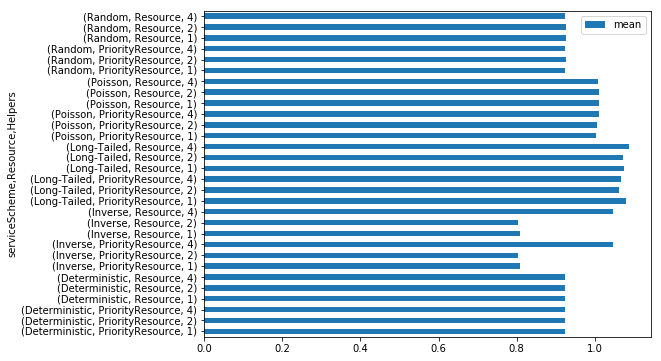

In [468]:
%matplotlib inline
grp = resourceStatsRun.groupby(["serviceScheme", "Resource", "Helpers"])
display(HTML(grp.Rho.agg([np.mean, np.var, np.std]).to_html()))

# grpDescr = grp.describe()
# grpDescr
# # display(HTML(grpDescr.ServeMean.to_html()))
# # display(HTML(grpDescr.Average.to_html()))

fig, ax = plt.subplots(figsize=(8,6))
grp.Rho.agg([np.mean]).plot(kind='barh', ax=ax)

In [111]:
display(HTML(grp.Average.agg([np.mean, np.var, np.std]).to_html()))

Long-Tailed_Resource_1               0.971333
Long-Tailed_Resource_2               0.970430
Long-Tailed_Resource_4               0.973369
Long-Tailed_PriorityResource_1       0.964239
Long-Tailed_PriorityResource_2       0.959924
Long-Tailed_PriorityResource_4       0.958787
Poisson_Resource_1                   0.932588
Poisson_Resource_2                   0.931317
Poisson_Resource_4                   0.929934
Poisson_PriorityResource_1           0.932925
Poisson_PriorityResource_2           0.930378
Poisson_PriorityResource_4           0.929169
Deterministic_Resource_1             0.923077
Deterministic_Resource_2             0.923077
Deterministic_Resource_4             0.923077
Deterministic_PriorityResource_1     0.923077
Deterministic_PriorityResource_2     0.923077
Deterministic_PriorityResource_4     0.923077
Inverse_Resource_1                   0.809697
Inverse_Resource_2                   0.803474
Inverse_Resource_4                   1.046414
Inverse_PriorityResource_1        

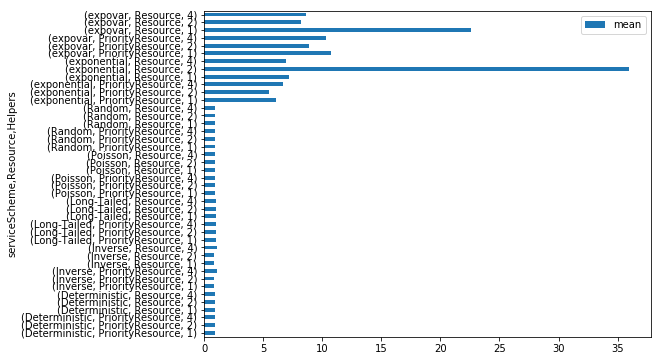

In [370]:
%matplotlib inline
grp = customerAll.groupby(["serviceScheme", "Resource", "Helpers"])
# display(HTML(grp.Average.agg([np.mean]).to_html()))
# display(HTML(grp.ServeMean.agg([np.mean, np.var, np.std]).to_html()))

# grpDescr = grp.describe()
# display(HTML(grpDescr.ServeMean.to_html()))
# display(HTML(grpDescr.Average.to_html()))

fig, ax = plt.subplots(figsize=(8,6))
grp.Rho.agg([np.mean]).plot(kind='barh', ax=ax)

customerAll.Rho

In [ ]:
resourceStatsRun